In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [3]:
source_folder = '/scratche/home/apoorv/repos/probe_kge/data/wnrr'
! ls {source_folder}

dataset.yaml	    test.txt		     valid.del
entity_ids.del	    test_without_unseen.del  valid.txt
entity_strings.del  train.del		     valid_without_unseen.del
relation_ids.del    train_sample.del
test.del	    train.txt


In [4]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

In [5]:
# load half data
data = {}
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(source_folder, split + '.txt')
    data[split] = readTriples(fname)

In [6]:
data['train'][5000]

['09429387', '_hypernym', '09385911']

In [7]:
len(data['train'])

86835

In [11]:
uniq_tails = set()
for t in data['train']:
    uniq_tails.add(t[2])
len(uniq_tails)

31881

In [49]:
def getPOS(name):
    return name[2:].split('_')[-2]

def processDefinition(definition):
    if '\"' in definition and ':' in definition:
        out = definition.split(':')[0]
    if ';' in definition:
        out = definition.split(';')[0]
    else:
        out = definition
    return out

def getAlias(name, definition):
    pos = getPOS(name)
    name = ' '.join(name[2:].split('_')[:-2])
    definition = processDefinition(definition)
    out = name + ', ' + pos + ' -- ' + definition
    return out

In [56]:
dest_folder = '/scratche/home/apoorv/transformer-kgc/data/wnrr'
aliases_dict = {}
# fname = os.path.join(dest_folder, 'wn-entity2text-new.txt')
fname = os.path.join(dest_folder, 'wordnet-mlj12-definitions.txt')
ent_names = []
definitions = []
aliases_set = set()
f = open(fname)
for line in f:
    line = line.rstrip().split('\t')
    ent_names.append(line[1])
    definitions.append(line[2])
    alias = getAlias(line[1], line[2])
    if alias in aliases_set:
        print(line, alias)
        alias = alias + ' 2'
    else:
        aliases_set.add(alias)
    aliases_dict[line[0]] = alias
f.close()

['02154312', '__spy_VB_1', 'catch sight of'] spy, VB -- catch sight of
['02073545', '__throw_off_VB_2', 'get rid of; "I couldn\'t shake the car that was following me"'] throw off, VB -- get rid of
['01397088', '__whop_VB_2', 'hit hard'] whop, VB -- hit hard
['00090708', '__mutilate_VB_3', 'destroy or injure severely; "mutilated bodies"'] mutilate, VB -- destroy or injure severely
['01872772', '__spiny_anteater_NN_1', 'a burrowing monotreme mammal covered with spines and having a long snout and claws for hunting ants and termites; native to New Guinea'] spiny anteater, NN -- a burrowing monotreme mammal covered with spines and having a long snout and claws for hunting ants and termites


In [57]:
len(aliases_dict), len(set(aliases_dict.values()))

(40943, 40943)

In [58]:
count = 0
for k, v in aliases_dict.items():
    print(v)
    count += 1
    if count == 100:
        break

stool, NN -- solid excretory product evacuated from the bowels
chieftainship, NN -- the position of chieftain
saxony, NN -- an area in Germany around the upper Elbe river
ondatra zibethica, NN -- beaver-like aquatic rodent of North America with dark glossy brown fur
founder, VB -- sink below the surface
rose campion, NN -- an old cottage garden plant of southeastern Europe widely cultivated for its attractive white woolly foliage and showy crimson flowers
enjoyment, NN -- the pleasure felt when having a good time
german shepherd dog, NN -- breed of large shepherd dogs used in police work and as a guide for the blind
quilt, VB -- stitch or sew together
wake island, NN -- an island in the western Pacific between Guam and Hawaii
raise, VB -- move upwards
admiralty, NN -- the department in charge of the navy (as in Great Britain)
opener, NN -- a hand tool used for opening sealed containers (bottles or cans)
watchman, NN -- a guard who keeps watch
reducing, NN -- loss of excess weight (as b

In [76]:
def triple2text(t):
    global aliases_dict
    rel = ' '.join(t[1][1:].split('_'))
    out = [aliases_dict[t[0]], rel, aliases_dict[t[2]]]
    return out

In [77]:
for t in data['train'][10:20]:
    print(triple2text(t))

['genus equisetum, NN -- horsetails', 'hypernym', 'fern genus, NN -- genera of ferns and fern allies']
['write, VB -- produce a literary work', 'also see', 'write up, VB -- put into writing']
['queen regnant, NN -- a female sovereign ruler', 'hypernym', 'female aristocrat, NN -- a woman who is an aristocrat']
['working dog, NN -- any of several breeds of usually large powerful dogs bred to work as draft animals and guard and guide dogs', 'hypernym', 'domestic dog, NN -- a member of the genus Canis (probably descended from the common wolf) that has been domesticated by man since prehistoric times']
['charge, NN -- request for payment of a debt', 'hypernym', 'request, NN -- the verbal act of requesting']
['primulaceae, NN -- a dicotyledonous family of the order Primulales with a regular flower', 'member meronym', 'glaux, NN -- sea milkwort']
['proteaceae, NN -- large family of Australian and South African shrubs and trees with leathery leaves and clustered mostly tetramerous flowers', 'm

In [63]:
from transformers import T5TokenizerFast
tokenizer = T5TokenizerFast.from_pretrained('t5-small')

In [72]:
from tqdm.notebook import tqdm
lengths = []
for k, v in tqdm(aliases_dict.items()):
    x = tokenizer(v)
    lengths.append(len(x['input_ids']))

Text(0.5, 0, 'Tokenized lengths')

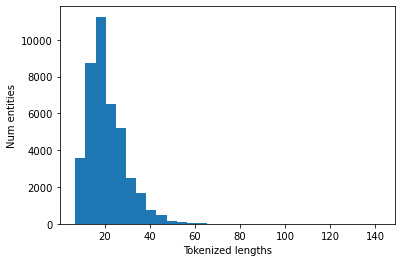

In [74]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [75]:
len(aliases_dict)

40943

In [78]:
def mapTriple(t, aliases_dict):
    out = triple2text(t)
    return out

In [79]:
for id in range(500):
    print(mapTriple(data['train'][id], aliases_dict))

['land reform, NN -- a redistribution of agricultural land (especially by government action)', 'hypernym', 'reform, NN -- a change for the better as a result of correcting abuses']
['cover, VB -- provide with a covering or cause to be covered', 'derivationally related form', 'covering, NN -- an artifact that covers something else (usually to protect or shelter or conceal it)']
['phytology, NN -- the branch of biology that studies plants', 'derivationally related form', 'botanize, VB -- collect and study plants']
['kamet, NN -- a mountain in the Himalayas in northern India (25,450 feet high)', 'instance hypernym', 'mountain peak, NN -- the summit of a mountain']
['question, NN -- an instance of questioning', 'derivationally related form', 'inquire, VB -- inquire about']
['class arachnida, NN -- a large class of arthropods including spiders and ticks and scorpions and daddy longlegs', 'derivationally related form', 'spidery, JJ -- relating to or resembling a member of the class Arachnida

In [80]:
len(data['train'])

86835

In [81]:
out_folder = dest_folder
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, aliases_dict)
        # only save those that DO NOT start with m. or g.
        # we can do that since aim is KGQA not KGC
        head, relation, tail = t
        input = 'predict tail: {0} | {1}'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1}'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [82]:
count

0

In [84]:
entity_names = set()
for key, value in aliases_dict.items():
#     if key.startswith('Q'):
    entity_names.add(value)
len(entity_names)

40943

In [85]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = entity_names
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [99]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [138]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half/train.txt', 
                                    model_prefix='fbwq_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

In [139]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_with_pad.model')

In [38]:
# sp['Obama']

0

In [151]:
sp.decode(sp.encode('how old'))

'how old'

In [192]:
sp.encode('<pad>')

[5, 0, 12497, 0]

In [195]:
sp['</s>']

2

In [193]:
sp.id_to_piece(3)

'<pad>'

In [176]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████| 1712213/1712213 [00:18<00:00, 91029.72it/s] 


0

Text(0.5, 0, 'Tokenized lengths')

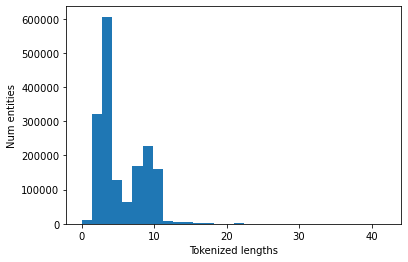

In [177]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

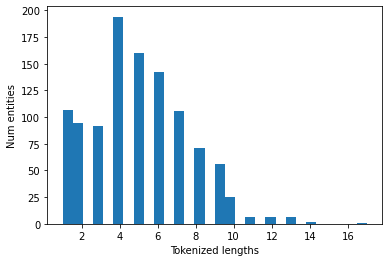

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)